In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import deep learning
import torch
from torch import nn

In [2]:
data = np.load("./Wafer_Map_Datasets.npz")
print(data.files)

['arr_0', 'arr_1']


Le fichier *Wafer Map Datasets* contient deux sous-fichiers:
   - **arr_0**: Fichier contenant les données représentant les wafers et leur défauts. Ce fichier contient à peu près 38000 images de format 52*52. Chaque élément de la matrice peut prendre 3 valeurs potentielles: 0 si c'est un point blanc, 1 si c'est une zone qui a passé le test éléctrique, et 2 si la zone n'a pas passée le test électrique.
   - **arr_1**: Contient les labels pour chacune des images. Chaque élément est un vecteur binaire de dimension 8. Chaque élément du vecteur correspond à un défaut basic unique. Si le défaut est présent sur l'image, alors la valeur est de 1, sinon elle est de 0.

In [3]:
train = data["arr_0"]
label = data["arr_1"]

In [4]:
len(data["arr_0"])

38015

In [5]:
len(train)

38015

In [6]:
label[1]

array([1, 0, 1, 0, 0, 0, 1, 0], dtype=int32)

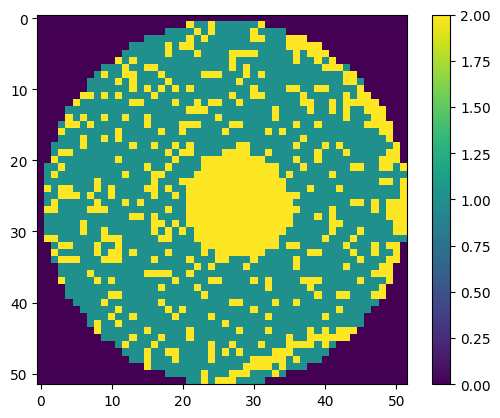

In [7]:
plt.imshow(train[1])
plt.colorbar();

In [8]:
t_train = torch.from_numpy(train)

In [9]:
t_train[1].shape

torch.Size([52, 52])

In [10]:
torch.from_numpy(train[1])

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [11]:
torch.from_numpy(label[1]).shape

torch.Size([8])

## Creating the dataset and dataloader for waferdataset on pytorch

In [12]:
from torch.utils.data import Dataset, DataLoader

In [13]:
class WaferDefaultDataset(Dataset):
    
    def __init__(self, dataset_dir, train, test_size=0.2):
        """
        dataset_dir : 'str', path to the directory of the wafer default dataset
        train: 'bool' a boolean used for splitting the of train and test datasets, if true it will return the
                training set, if False, it will return the test set
        test_size: 'float' a float between 0 and 1 (default 0.2) for splitting the dataset between train and test sets
        """
        
        self.data = np.load(dataset_dir)
        self.fullsize = len(self.data["arr_1"])
        self.train = train # boolean used to split a train set from a test set
        self.split_idx = int(self.fullsize * (1-test_size))
        
        if self.train:
            
            self.datasamples = self.data["arr_0"][:self.split_idx]
            self.labels = self.data["arr_1"][:self.split_idx]
        
        else:
            
            self.datasamples = self.data["arr_0"][self.split_idx:]
            self.labels = self.data["arr_1"][self.split_idx:]
            
            
    
    def __len__(self):
        
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        sample = self.datasamples[idx]
        label = self.labels[idx]
        
        return torch.from_numpy(sample.astype('float32')).unsqueeze(0), torch.from_numpy(label.astype('float32')).unsqueeze(0)

In [14]:
training_data = WaferDefaultDataset("./Wafer_Map_Datasets.npz", True)
test_data = WaferDefaultDataset("./Wafer_Map_Datasets.npz", False)

### Creating dataloaders

In [15]:
train_dataloader = DataLoader(training_data, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=True)

# Développement du réseau de neurone

In [16]:
from torchvision.ops import deform_conv2d

In [17]:
class DefConvNetBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, 
                 kernel_size, defconv=False):
        
        super().__init__()
        
        # Creating Deformable Convolutional Network
        if defconv: 
            self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=out_channels, 
                          kernel_size=kernel_size),
                deform_conv2d(),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=out_channels, 
                          kernel_size=kernel_size),
                nn.BatchNorm2d(out_channels),
            )
    def forward(self, x):
        x = self.block(x)
        return x

In [18]:
import torch.nn.functional as F

class DCNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.module1 = DefConvNetBlock(1, 32, kernel_size=5)
        self.module2 = DefConvNetBlock(32, 64, kernel_size=3)
        self.module3 = DefConvNetBlock(64, 128, kernel_size=3)
        self.module4 = DefConvNetBlock(128, 128, kernel_size=3)
        
        self.fc1 = nn.Linear(42*42*128, 128)
        self.fc2 = nn.Linear(128, 8)
    
    def forward(self, x):
        
        x = self.module1(x)
        x = F.relu(x)
        
        x = self.module2(x)
        x = F.relu(x)
        
        x = self.module3(x)
        x = F.relu(x)
        
        x = self.module4(x)
        x = F.relu(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        
        # creating output
        output = torch.sigmoid(x)
        return output

In [19]:
# model = DCNet()
model2 = DCNet()

In [20]:
model2.parameters()

<generator object Module.parameters at 0x72fbc8ee3920>

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2.to(device)

DCNet(
  (module1): DefConvNetBlock(
    (block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (module2): DefConvNetBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (module3): DefConvNetBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (module4): DefConvNetBlock(
    (block): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc1): Linear(in_features=225792, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=Tr

In [22]:
from torchsummary import summary
summary(model2, input_size=(1, 52, 52))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             832
       BatchNorm2d-2           [-1, 32, 48, 48]              64
   DefConvNetBlock-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 46, 46]          18,496
       BatchNorm2d-5           [-1, 64, 46, 46]             128
   DefConvNetBlock-6           [-1, 64, 46, 46]               0
            Conv2d-7          [-1, 128, 44, 44]          73,856
       BatchNorm2d-8          [-1, 128, 44, 44]             256
   DefConvNetBlock-9          [-1, 128, 44, 44]               0
           Conv2d-10          [-1, 128, 42, 42]         147,584
      BatchNorm2d-11          [-1, 128, 42, 42]             256
  DefConvNetBlock-12          [-1, 128, 42, 42]               0
           Linear-13                  [-1, 128]      28,901,504
           Linear-14                   

### Defining hyperparameters for the model according to the paper

In [23]:
learning_rate = 1e-4
batch_size = 1024
decay = 1e-6
momentum = 0.9
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, weight_decay=decay, momentum=momentum)

In [24]:
# epochs = 4800
epochs = 10

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
log_interval = 100

## Training the model

In [30]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    running_loss = 0.0
    correct = 0
    total = 0
    print("model.train level")
    model2.train()
    print("model.train() over")
    size = len(train_dataloader.dataset)
    print(size)
    for i, data in enumerate(train_dataloader):
        print("inside the loop!")
        inputs, labels = data[0].to(device), data[1].squeeze(1).to(device)
             
        # Forward pass
        print("forward pass")
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        print("backward pass")
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i % 10 == 0:
            loss, current = loss.item(), i * batch_size + len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
#     print("before model.eval()")    
#     model2.eval()
#     print("after model.eval()")
#     size = len(test_dataloader.dataset)
#     num_batches = len(test_dataloader)
#     test_loss, correct = 0, 0
    
#     with torch.no_grad():
#         print("at test level")
#         for X, y in test_dataloader:
#             y = y.squeeze(1)
#             pred = model2(X)
#             test_loss += criterion(pred, y).item()
#             pred = pred > 0.8
#             correct += (pred == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
print("Training Done")

Epoch 1
-------------------------------
model.train level
model.train() over
30412
inside the loop!
forward pass


OutOfMemoryError: CUDA out of memory. Tried to allocate 882.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 400.94 MiB is free. Including non-PyTorch memory, this process has 4.69 GiB memory in use. Of the allocated memory 4.47 GiB is allocated by PyTorch, and 90.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [34]:
import gc
torch._C._cuda_clearCublasWorkspaces()
torch._dynamo.reset()
gc.collect()
torch.cuda.empty_cache()

In [32]:
del model2
del criterion
del optimizer

In [33]:
del labels

In [33]:
gc.collect()

545